# hospital data curation project
## phase 7: regression analysis - predicting length of stay

objective: predict length of stay (los) using patient demographics, diagnosis, and admission type

models: linear regression, ridge regression, lasso regression

evaluation metrics: rmse, mae, r²

In [1]:
# import required libraries
import sys
import os
from pathlib import Path

# add src directory to python path
notebook_dir = Path(os.getcwd())
src_dir = notebook_dir / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# import project modules
import config
import utils

# use imported modules
PREPROCESSED_DATA_DIR = config.PREPROCESSED_DATA_DIR
MODELS_DIR = config.MODELS_DIR
VISUALIZATIONS_DIR = config.VISUALIZATIONS_DIR
RANDOM_SEED = config.RANDOM_SEED
setup_logging = utils.setup_logging
print_section_header = utils.print_section_header
load_dataframe = utils.load_dataframe


## 1. load and prepare data

In [2]:
# setup
logger = setup_logging()
np.random.seed(RANDOM_SEED)

# load transformed dataset
print_section_header("loading data for regression analysis")

master_df = load_dataframe(PREPROCESSED_DATA_DIR / 'transformed_master_dataset.csv')

print(f"dataset loaded: {len(master_df)} rows, {len(master_df.columns)} columns")
print(f"\navailable columns: {list(master_df.columns)}")

2025-11-10 17:56:02,158 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\transformed_master_dataset.csv: 2481 rows, 36 columns



                      loading data for regression analysis                      

dataset loaded: 2481 rows, 36 columns

available columns: ['patient_id', 'name', 'dob', 'gender', 'contact_number', 'email', 'address', 'visit_id', 'admission_date', 'discharge_date', 'admission_type', 'hospital_unit_id', 'attending_physician_id', 'length_of_stay', 'diagnosis_count', 'primary_diagnosis', 'all_diagnoses', 'medication_count', 'all_medications', 'staff_id', 'name_staff', 'designation', 'unit_id', 'joining_date', 'days_since_last_admission', 'is_readmitted', 'los_category', 'is_high_risk', 'length_of_stay_normalized', 'diagnosis_count_normalized', 'medication_count_normalized', 'admission_year', 'admission_month', 'admission_day_of_week', 'admission_quarter', 'is_weekend_admission']


## 2. feature selection for regression

In [3]:
# select features for predicting length of stay
print_section_header("feature selection")

# target variable
target = 'length_of_stay'

# predictor features
feature_columns = []

# demographic features
if 'age' in master_df.columns:
    feature_columns.append('age')

if 'gender' in master_df.columns:
    # encode gender
    master_df['gender_encoded'] = master_df['gender'].map({'Male': 1, 'Female': 0, 'Other': 2}).fillna(0)
    feature_columns.append('gender_encoded')

# clinical features
if 'diagnosis_count' in master_df.columns:
    feature_columns.append('diagnosis_count')

if 'medication_count' in master_df.columns:
    feature_columns.append('medication_count')

# admission features
if 'is_weekend_admission' in master_df.columns:
    feature_columns.append('is_weekend_admission')

if 'admission_month' in master_df.columns:
    feature_columns.append('admission_month')

# risk factors
if 'is_high_risk' in master_df.columns:
    feature_columns.append('is_high_risk')

print(f"selected features for regression:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i}. {feature}")

print(f"\ntarget variable: {target}")


                               feature selection                                

selected features for regression:
  1. gender_encoded
  2. diagnosis_count
  3. medication_count
  4. is_weekend_admission
  5. admission_month
  6. is_high_risk

target variable: length_of_stay


## 3. prepare training and test sets

In [4]:
# prepare data for modeling
print_section_header("preparing train/test split")

# filter out missing values
regression_df = master_df[[target] + feature_columns].copy()
regression_df = regression_df.dropna()

print(f"samples after removing missing values: {len(regression_df)}")

# separate features and target
X = regression_df[feature_columns]
y = regression_df[target]

# train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"\ntrain set: {len(X_train)} samples")
print(f"test set: {len(X_test)} samples")

# display target statistics
print(f"\ntarget (length of stay) statistics:")
print(f"  train - mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")
print(f"  test - mean: {y_test.mean():.2f}, std: {y_test.std():.2f}")


                           preparing train/test split                           

samples after removing missing values: 2481

train set: 1984 samples
test set: 497 samples

target (length of stay) statistics:
  train - mean: 182.32, std: 104.86
  test - mean: 182.05, std: 106.00


## 4. feature scaling

In [5]:
# standardize features
print_section_header("feature scaling")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("features standardized using standardscaler")
print("mean ~0, standard deviation ~1")

# save scaler for future use
scaler_file = MODELS_DIR / 'los_feature_scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"\nscaler saved to: {scaler_file}")


                                feature scaling                                 

features standardized using standardscaler
mean ~0, standard deviation ~1

scaler saved to: d:\Github Desktop\Python\Hospital Data Curation\models\los_feature_scaler.pkl


## 5. linear regression model

In [6]:
# train linear regression model
print_section_header("linear regression")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# evaluation metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("performance metrics:")
print(f"\ntrain set:")
print(f"  rmse: {train_rmse_lr:.3f} days")
print(f"  mae: {train_mae_lr:.3f} days")
print(f"  r²: {train_r2_lr:.3f}")

print(f"\ntest set:")
print(f"  rmse: {test_rmse_lr:.3f} days")
print(f"  mae: {test_mae_lr:.3f} days")
print(f"  r²: {test_r2_lr:.3f}")

# feature importance
print("\nfeature coefficients:")
for feature, coef in zip(feature_columns, lr_model.coef_):
    print(f"  {feature}: {coef:.4f}")

# save model
model_file = MODELS_DIR / 'linear_regression_los.pkl'
joblib.dump(lr_model, model_file)
print(f"\nmodel saved to: {model_file}")


                               linear regression                                

performance metrics:

train set:
  rmse: 104.530 days
  mae: 90.292 days
  r²: 0.006

test set:
  rmse: 105.975 days
  mae: 92.028 days
  r²: -0.001

feature coefficients:
  gender_encoded: -0.1028
  diagnosis_count: 1.3748
  medication_count: 1.5846
  is_weekend_admission: -3.8149
  admission_month: -3.7004
  is_high_risk: 4.6776

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\linear_regression_los.pkl


## 6. ridge regression model

In [7]:
# train ridge regression model (l2 regularization)
print_section_header("ridge regression")

ridge_model = Ridge(alpha=1.0, random_state=RANDOM_SEED)
ridge_model.fit(X_train_scaled, y_train)

# predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# evaluation metrics
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print("performance metrics:")
print(f"\ntrain set:")
print(f"  rmse: {train_rmse_ridge:.3f} days")
print(f"  mae: {train_mae_ridge:.3f} days")
print(f"  r²: {train_r2_ridge:.3f}")

print(f"\ntest set:")
print(f"  rmse: {test_rmse_ridge:.3f} days")
print(f"  mae: {test_mae_ridge:.3f} days")
print(f"  r²: {test_r2_ridge:.3f}")

# save model
model_file = MODELS_DIR / 'ridge_regression_los.pkl'
joblib.dump(ridge_model, model_file)
print(f"\nmodel saved to: {model_file}")


                                ridge regression                                

performance metrics:

train set:
  rmse: 104.530 days
  mae: 90.292 days
  r²: 0.006

test set:
  rmse: 105.975 days
  mae: 92.028 days
  r²: -0.001

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\ridge_regression_los.pkl


## 7. lasso regression model

In [8]:
# train lasso regression model (l1 regularization)
print_section_header("lasso regression")

lasso_model = Lasso(alpha=0.1, random_state=RANDOM_SEED, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

# predictions
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

# evaluation metrics
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
train_mae_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print("performance metrics:")
print(f"\ntrain set:")
print(f"  rmse: {train_rmse_lasso:.3f} days")
print(f"  mae: {train_mae_lasso:.3f} days")
print(f"  r²: {train_r2_lasso:.3f}")

print(f"\ntest set:")
print(f"  rmse: {test_rmse_lasso:.3f} days")
print(f"  mae: {test_mae_lasso:.3f} days")
print(f"  r²: {test_r2_lasso:.3f}")

# feature selection by lasso
print("\nfeature importance (lasso coefficients):")
for feature, coef in zip(feature_columns, lasso_model.coef_):
    if abs(coef) > 0.001:
        print(f"  {feature}: {coef:.4f}")

# save model
model_file = MODELS_DIR / 'lasso_regression_los.pkl'
joblib.dump(lasso_model, model_file)
print(f"\nmodel saved to: {model_file}")


                                lasso regression                                

performance metrics:

train set:
  rmse: 104.531 days
  mae: 90.297 days
  r²: 0.006

test set:
  rmse: 105.960 days
  mae: 92.025 days
  r²: -0.001

feature importance (lasso coefficients):
  gender_encoded: -0.0026
  diagnosis_count: 1.3156
  medication_count: 1.4828
  is_weekend_admission: -3.7103
  admission_month: -3.5990
  is_high_risk: 4.6262

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\lasso_regression_los.pkl


## 8. model comparison

In [9]:
# compare all models
print_section_header("model comparison")

comparison_df = pd.DataFrame({
    'model': ['linear regression', 'ridge regression', 'lasso regression'],
    'train_rmse': [train_rmse_lr, train_rmse_ridge, train_rmse_lasso],
    'test_rmse': [test_rmse_lr, test_rmse_ridge, test_rmse_lasso],
    'train_mae': [train_mae_lr, train_mae_ridge, train_mae_lasso],
    'test_mae': [test_mae_lr, test_mae_ridge, test_mae_lasso],
    'train_r2': [train_r2_lr, train_r2_ridge, train_r2_lasso],
    'test_r2': [test_r2_lr, test_r2_ridge, test_r2_lasso]
})

print(comparison_df.to_string(index=False))

# identify best model based on test rmse
best_model_idx = comparison_df['test_rmse'].idxmin()
best_model = comparison_df.iloc[best_model_idx]['model']
print(f"\nbest model (lowest test rmse): {best_model}")

# save comparison
comparison_file = MODELS_DIR / 'regression_model_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"comparison saved to: {comparison_file}")


                                model comparison                                

            model  train_rmse  test_rmse  train_mae  test_mae  train_r2   test_r2
linear regression  104.530297 105.974927  90.292414 92.027624  0.005783 -0.001454
 ridge regression  104.530298 105.974981  90.292471 92.027865  0.005783 -0.001456
 lasso regression  104.530545 105.960289  90.297439 92.024668  0.005778 -0.001178

best model (lowest test rmse): lasso regression
comparison saved to: d:\Github Desktop\Python\Hospital Data Curation\models\regression_model_comparison.csv


## 9. visualizations


                           generating visualizations                            

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\regression_actual_vs_predicted.png


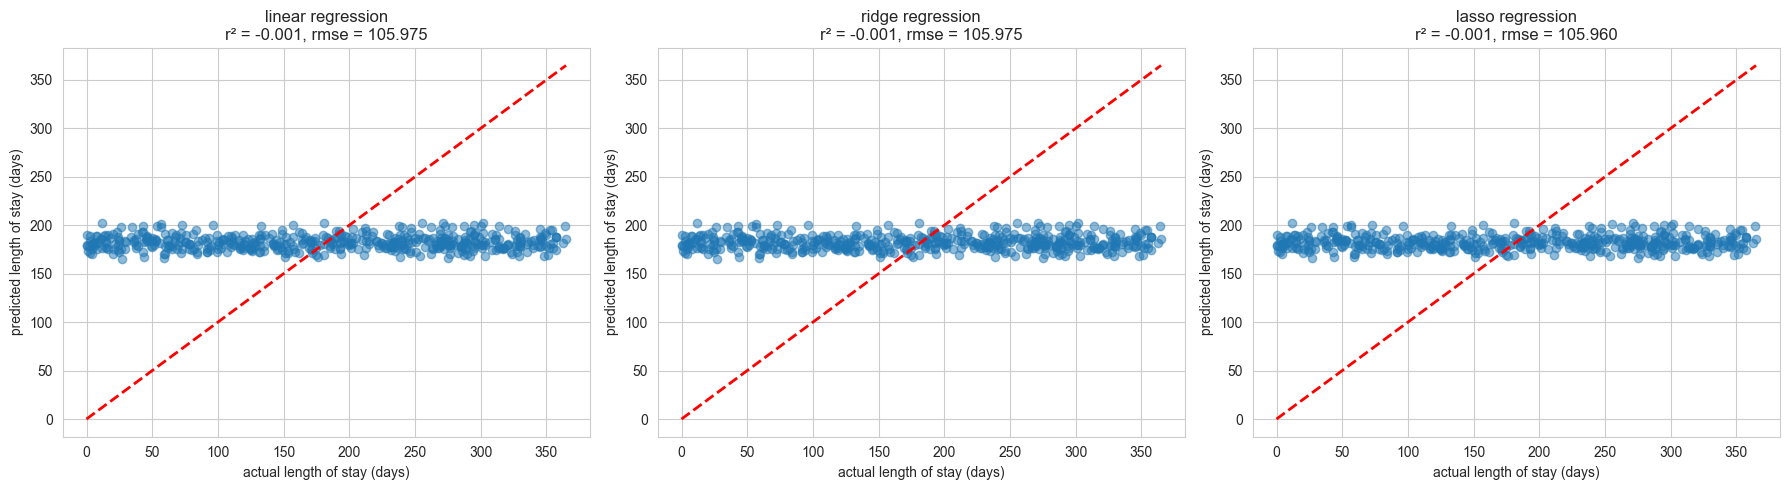

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\regression_model_comparison.png


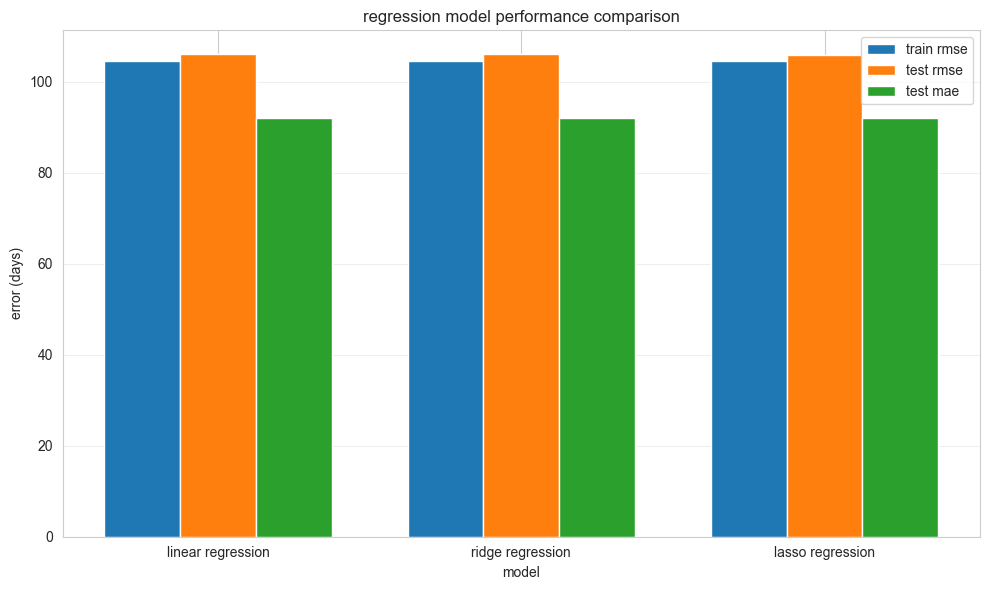

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\regression_residuals.png


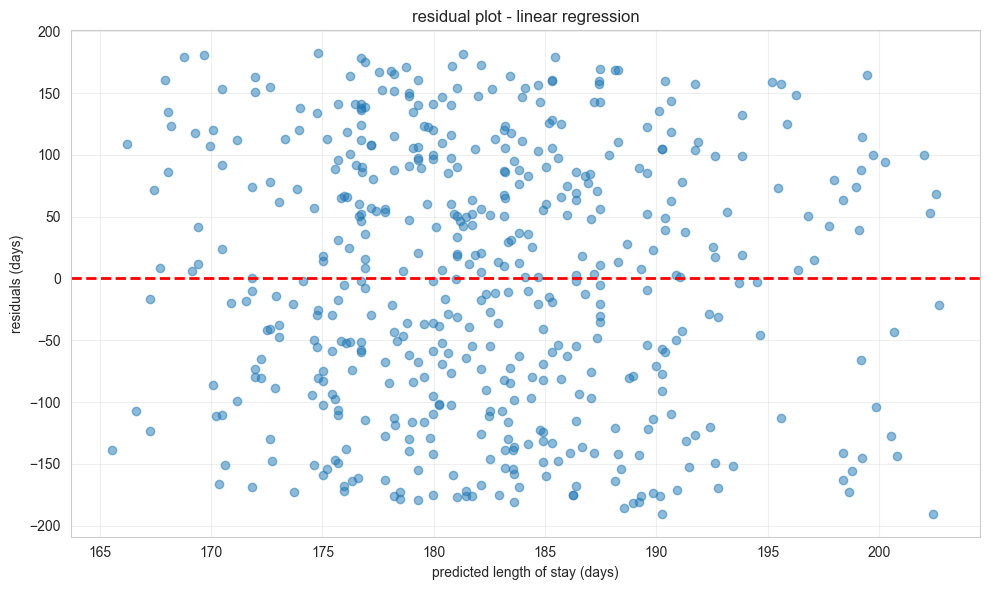


all visualizations saved to visualizations/


In [10]:
# create visualizations
print_section_header("generating visualizations")

# set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 1. actual vs predicted scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# linear regression
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('actual length of stay (days)')
axes[0].set_ylabel('predicted length of stay (days)')
axes[0].set_title(f'linear regression\nr² = {test_r2_lr:.3f}, rmse = {test_rmse_lr:.3f}')

# ridge regression
axes[1].scatter(y_test, y_test_pred_ridge, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('actual length of stay (days)')
axes[1].set_ylabel('predicted length of stay (days)')
axes[1].set_title(f'ridge regression\nr² = {test_r2_ridge:.3f}, rmse = {test_rmse_ridge:.3f}')

# lasso regression
axes[2].scatter(y_test, y_test_pred_lasso, alpha=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('actual length of stay (days)')
axes[2].set_ylabel('predicted length of stay (days)')
axes[2].set_title(f'lasso regression\nr² = {test_r2_lasso:.3f}, rmse = {test_rmse_lasso:.3f}')

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'regression_actual_vs_predicted.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

# 2. model performance comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['train_rmse'], width, label='train rmse')
ax.bar(x, comparison_df['test_rmse'], width, label='test rmse')
ax.bar(x + width, comparison_df['test_mae'], width, label='test mae')

ax.set_xlabel('model')
ax.set_ylabel('error (days)')
ax.set_title('regression model performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'regression_model_comparison.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

# 3. residuals plot
residuals = y_test - y_test_pred_lr
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test_pred_lr, residuals, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('predicted length of stay (days)')
ax.set_ylabel('residuals (days)')
ax.set_title('residual plot - linear regression')
ax.grid(alpha=0.3)

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'regression_residuals.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

print("\nall visualizations saved to visualizations/")

## summary

regression analysis completed:

models trained:
- ✓ linear regression
- ✓ ridge regression (l2 regularization)
- ✓ lasso regression (l1 regularization)

key findings:
- models predict length of stay based on patient demographics and clinical factors
- feature importance identified through coefficients
- model comparison shows performance across train/test sets
- visualizations demonstrate prediction accuracy

all models and results saved to `models/` and `visualizations/`